In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

In [2]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /voc/work/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /voc/work/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /voc/work/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /voc/work/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
# Load the dataset
data = pd.read_csv('Tesla - Deaths.csv')

In [4]:
data.head()

,Case #,Year,Date,Country,State,Description,Deaths,Tesla driver,Tesla occupant,Other vehicle,...,Verified Tesla Autopilot Deaths,Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO,Unnamed: 16,Unnamed: 17,Source,Note,Deceased 1,Deceased 2,Deceased 3,Deceased 4
0,294.0,2022.0,1/17/2023,USA,CA,Tesla crashes into back of semi,1.0,1,-,-,...,-,-,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20230118162813/ht...,NaN,NaN,NaN,NaN,NaN
1,293.0,2022.0,1/7/2023,Canada,-,Tesla crashes,1.0,1,-,-,...,-,-,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20230109041434/ht...,NaN,Taren Singh Lal,NaN,NaN,NaN
2,292.0,2022.0,1/7/2023,USA,WA,"Tesla hits pole, catches on fire",1.0,-,1,-,...,-,-,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20230107232745/ht...,NaN,NaN,NaN,NaN,NaN
3,291.0,2022.0,12/22/2022,USA,GA,Tesla crashes and burns,1.0,1,-,-,...,-,-,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20221222203930/ht...,NaN,NaN,NaN,NaN,NaN
4,290.0,2022.0,12/19/2022,Canada,-,Tesla crashes into storefront,1.0,-,-,-,...,-,-,https://web.archive.org/web/20221223203725/ht...,https://web.archive.org/web/20221223203725/ht...,https://web.archive.org/web/20221223203725/ht...,NaN,NaN,NaN,NaN,NaN


#### Perform preliminary data inspection checking for data types, missing values, duplicates.Verified Tesla Autopilot DeathsVerified Tesla Autopilot Deaths

In [5]:
# Function to visualize missing data
def plot_missing_data(df):
    plt.figure(figsize=(12, 6))
    msno.heatmap(df, cmap="viridis")
    plt.title("Missing Data Heatmap")
    plt.show()

<Figure size 864x432 with 0 Axes>

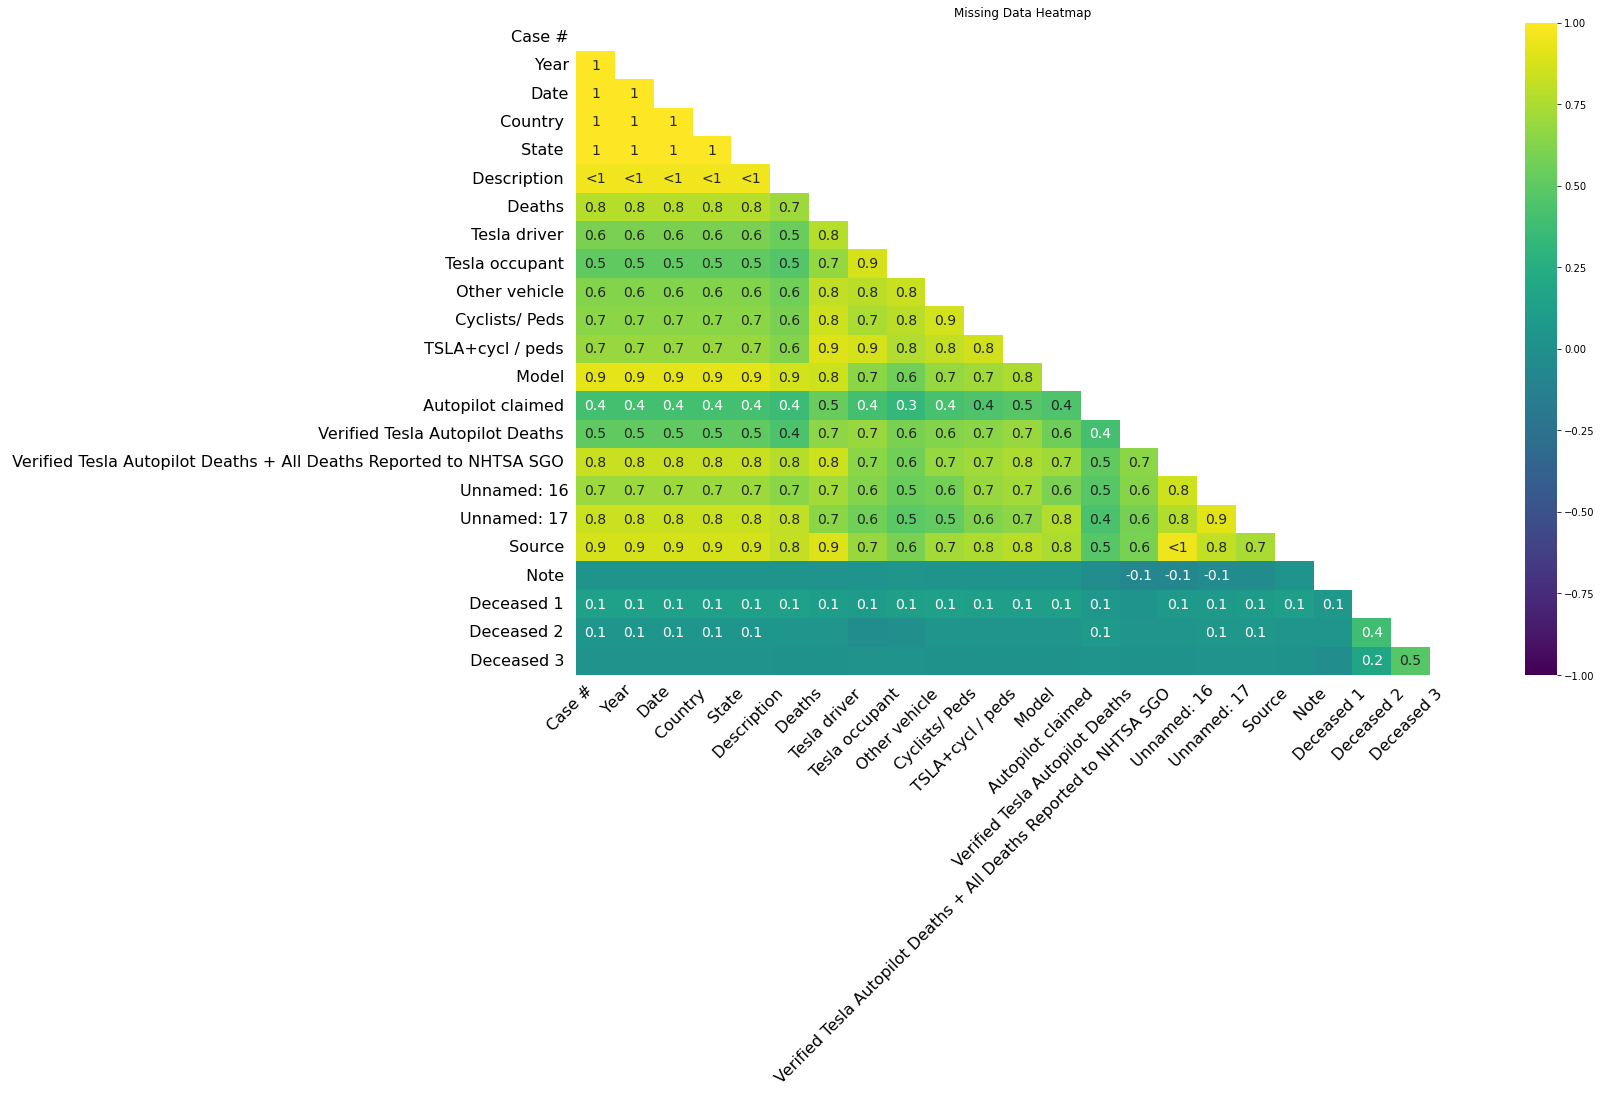

In [6]:
# Plot initial missing data for inspection
plot_missing_data(data)

#### Remove any columns which might not be relevant for the analysis.


#### Unnamed: 16 & Unnamed: 17 contain web link which is not useful 
#### Source : contains web link
#### Note : contains additional info 
#### Deceased 1 2 3 and 4 contain name of the deceased which is irrelevant to the analysis.
#### Case # not required
#### Year can be derived from date

On closer analysis we find that variable *' Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO '*  also contain mostly '-' which represent empty or missing hence we remove this column also

In [7]:
# Drop irrelevant columns after confirming their lack of analytical value
drop_columns = [
    'Case #', 'Year', 'Unnamed: 16', 'Unnamed: 17', ' Source ', ' Note ',
    ' Deceased 1 ', ' Deceased 2 ', ' Deceased 3 ', ' Deceased 4 ',
    ' Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO '
]
data.drop(columns=drop_columns, inplace=True)

<Figure size 864x432 with 0 Axes>

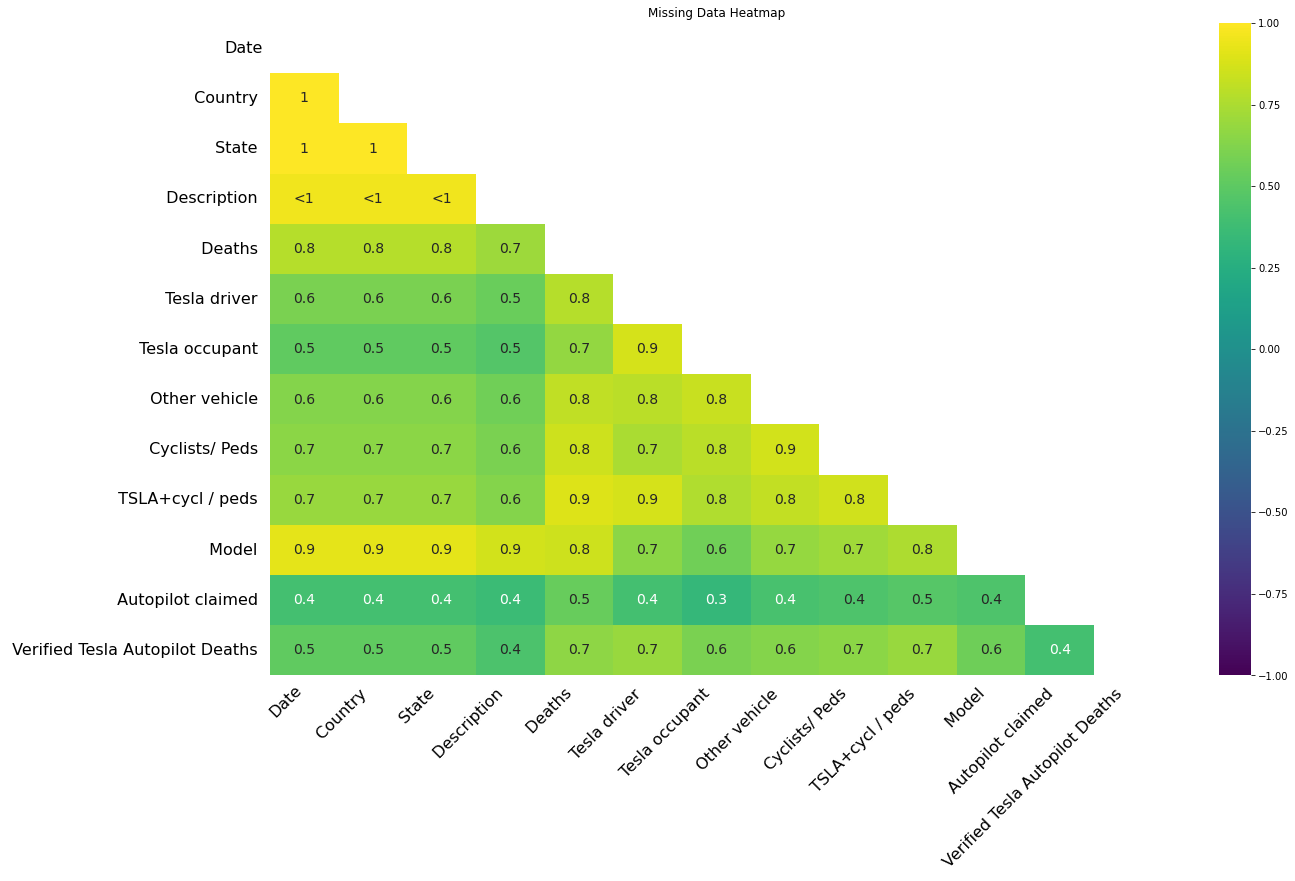

In [8]:
# Check missing data again after column removal
plot_missing_data(data)


#### We still have missing so we will impute 
Missing values may be in other forms also like in this data they are in "-"

In [9]:
# Replace "-" with 0 for numerical columns, excluding "Model" which is categorical
for col in data.columns[5:]:
    if col != ' Model ':
        data[col] = data[col].fillna("-").str.strip().replace("-", "0").astype(int)

### Change the variable names in accordance to the python norms

In [10]:
# Update column names to follow Python naming conventions and improve readability
data.columns = data.columns.str.strip().str.replace(" ", "", regex=True).str.replace("[+/]", "_", regex=True)
data.rename(columns={
    "Autopilotclaimed": "Claimed", "VerifiedTeslaAutopilotDeaths": "VTAD",
    "Teslaoccupant": "Tesla_Occupant", "Othervehicle": "Other_Vehicle",
    "Tesladriver": "Tesla_Driver"
}, inplace=True)


<Figure size 864x432 with 0 Axes>

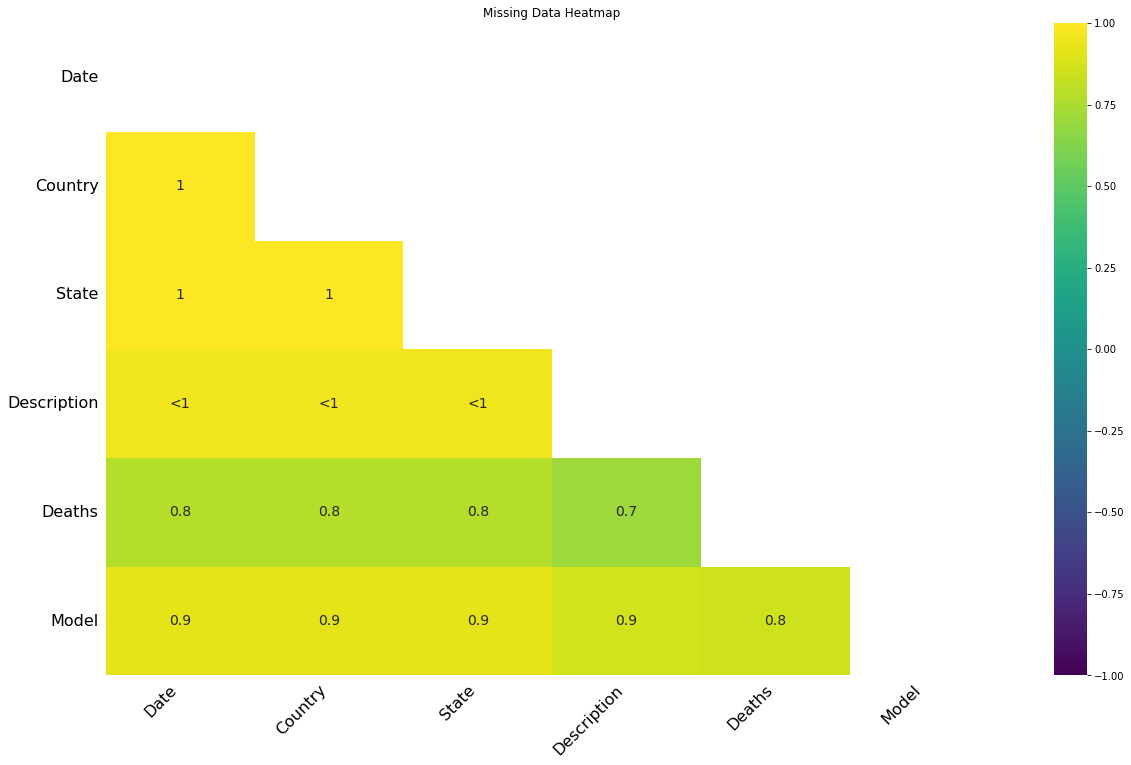

In [11]:
# Final missing data check after all transformations
plot_missing_data(data)

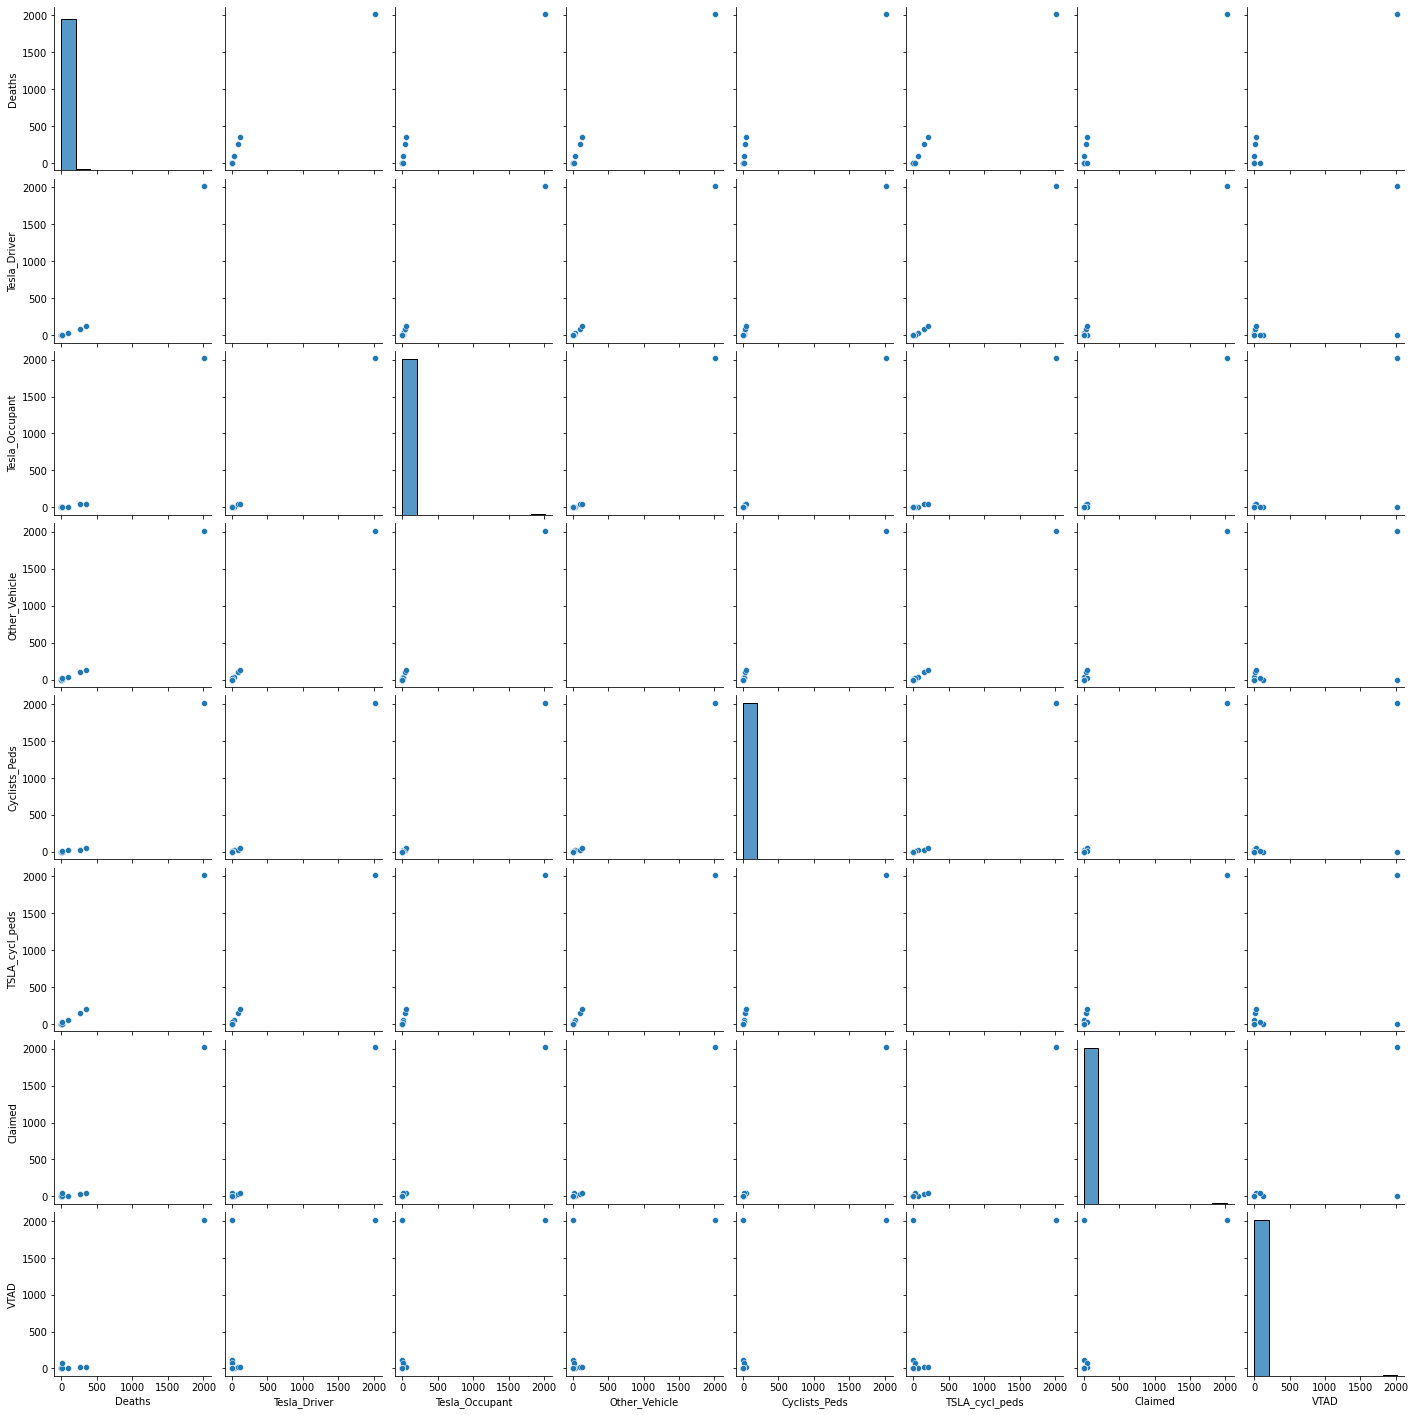

In [13]:
# Pairplot for initial overview of relationships between numerical columns
sns.pairplot(data.select_dtypes(include=[np.number]))
plt.show()

### Comparing Deaths and VTAD columns to get better understanding of the dataset.

In [12]:
# Display unique values in the 'Deaths' and 'VTAD' columns for anomaly detection
print("Unique values in 'Deaths' column:", data['Deaths'].unique())
print("Unique values in 'VTAD' column:", data['VTAD'].unique())

# Investigate any unusually high values in 'Deaths' and 'VTAD' columns that may indicate data quality issues
# For example, filter rows where 'Deaths' or 'VTAD' has values that seem unrealistic or require further verification
unusual_deaths = data[data['Deaths'] > 10]  # Assuming deaths > 10 is unusual in a single accident
unusual_vtad = data[data['VTAD'] > 10]  # Assuming VTAD values > 10 may be anomalous for single incidents

# Display the rows with potential anomalies for further investigation
print("\nRows with unusual values in 'Deaths':")
print(unusual_deaths[['Date', 'Country', 'State', 'Deaths', 'VTAD', 'Description']])

print("\nRows with unusual values in 'VTAD':")
print(unusual_vtad[['Date', 'Country', 'State', 'Deaths', 'VTAD', 'Description']])

# Count occurrences of each value in 'Deaths' and 'VTAD' for further insight into typical values
print("\nValue counts in 'Deaths' column:")
print(data['Deaths'].value_counts().sort_index())

print("\nValue counts in 'VTAD' column:")
print(data['VTAD'].value_counts().sort_index())


Unique values in 'Deaths' column: [1.000e+00 2.000e+00 4.000e+00 3.000e+00 9.200e+01 2.610e+02 3.530e+02
       nan 2.013e+03]
Unique values in 'VTAD' column: [   0    1    2    3   16   19  118 2022   75 2021]

Rows with unusual values in 'Deaths':
    Date Country State  Deaths  VTAD Description
294  NaN     NaN   NaN    92.0     3         NaN
295  NaN     NaN   NaN   261.0    16         NaN
296  NaN     NaN   NaN   353.0    19         NaN
301  NaN     NaN   NaN  2013.0  2021         NaN

Rows with unusual values in 'VTAD':
    Date Country State  Deaths  VTAD Description
295  NaN     NaN   NaN   261.0    16         NaN
296  NaN     NaN   NaN   353.0    19         NaN
298  NaN     NaN   NaN     NaN   118         NaN
299  NaN     NaN   NaN     NaN  2022         NaN
300  NaN     NaN   NaN     3.0    75         NaN
301  NaN     NaN   NaN  2013.0  2021         NaN

Value counts in 'Deaths' column:
1.0       247
2.0        38
3.0         7
4.0         3
92.0        1
261.0       1
353.0  

## Exploratory Data Analysis 

### Perform an in depth exploratory data analysis. Analysing the number of events by date, per year , per day for each state and country.

In [14]:
# Convert 'Date' column to datetime for time-based analysis and add year, month, day
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data['event_year'] = data['Date'].dt.year
data['event_month'] = data['Date'].dt.month
data['event_day'] = data['Date'].dt.day

# Filter data to remove events from incomplete year 2023 for clearer trends
data = data[data['event_year'] != 2023]

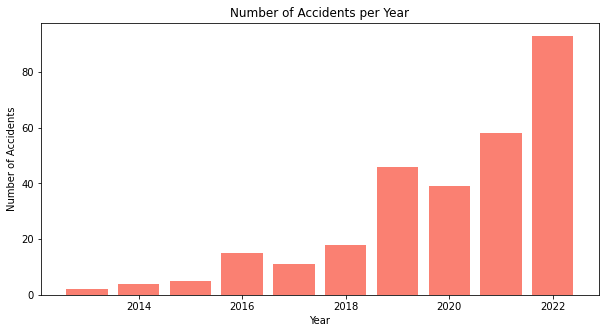

In [15]:
# Yearly analysis: Accidents per year (Adjusted for better context if sales data available)
yearly_counts = data['event_year'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
plt.bar(yearly_counts.index, yearly_counts.values, color="salmon")
plt.xlabel("Year")
plt.ylabel("Number of Accidents")
plt.title("Number of Accidents per Year")
plt.show()

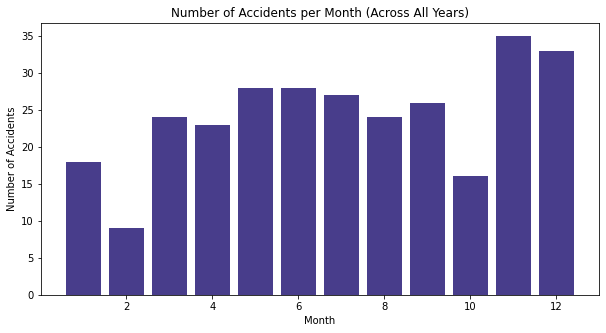

In [16]:
# Monthly analysis: Accidents per month (Across all years)
monthly_counts = data['event_month'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
plt.bar(monthly_counts.index, monthly_counts.values, color="darkslateblue")
plt.xlabel("Month")
plt.ylabel("Number of Accidents")
plt.title("Number of Accidents per Month (Across All Years)")
plt.show()


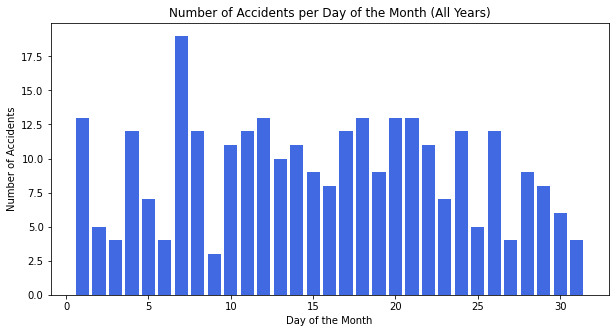

In [17]:
# Daily analysis: Accidents per day (All years, improved with bar plot consistency)
daily_counts = data['event_day'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
plt.bar(daily_counts.index, daily_counts.values, color="royalblue")
plt.xlabel("Day of the Month")
plt.ylabel("Number of Accidents")
plt.title("Number of Accidents per Day of the Month (All Years)")
plt.show()

### Conclusion :
- Tesla's accident volume tends to increase every year
- The number of accidents in November and December is the highest.
- Day wise no concrete info as the distribution pattern is irregular

##### However for year wise pattern we should be considering the accidents vs sales data. More Tesla on road will definetly bring a rise in no. of accidents while proportion of accidents might not increase as such. 

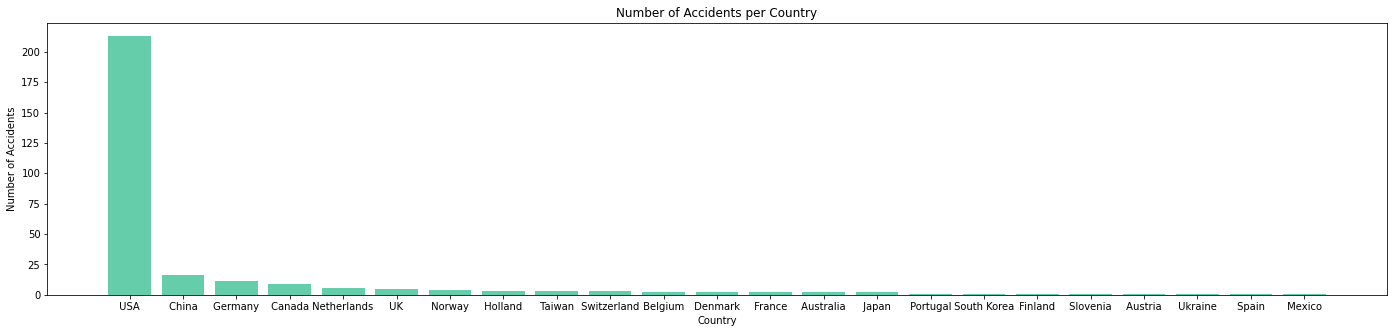

In [18]:
# Country-wise analysis
country_counts = data['Country'].value_counts()
plt.figure(figsize=(24, 5))
plt.bar(country_counts.index, country_counts.values, color="mediumaquamarine")
plt.xlabel("Country")
plt.ylabel("Number of Accidents")
plt.title("Number of Accidents per Country")
plt.show()

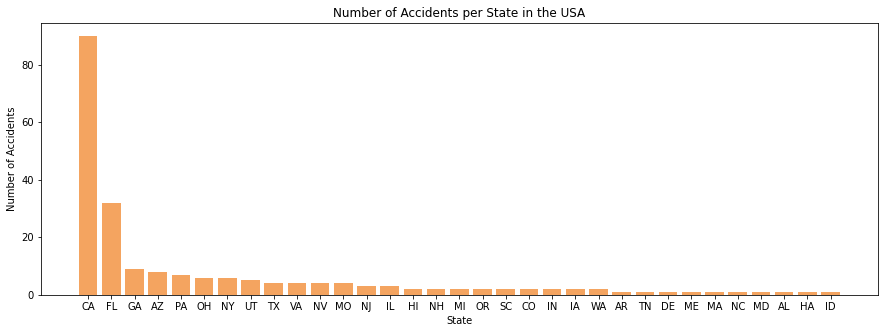

In [19]:
# State-wise analysis within the USA for more granularity
state_counts = data['State'].str.strip().replace("-", np.nan).value_counts()
plt.figure(figsize=(15, 5))
plt.bar(state_counts.index, state_counts.values, color="sandybrown")
plt.xlabel("State")
plt.ylabel("Number of Accidents")
plt.title("Number of Accidents per State in the USA")
plt.show()

In [ ]:
# Analyze accident impact factors, e.g., Deaths per accident, Tesla drivers involved
impact_cols = ['Deaths', 'Tesla_Driver', 'Tesla_Occupant', 'Other_Vehicle', 'Cyclists_Peds', 'TSLA_cycl_peds']
impact_colors = ['salmon', 'mediumaquamarine', 'mediumpurple', 'goldenrod', 'silver', 'saddlebrown']
plt.figure(figsize=(18, 10))
for idx, col in enumerate(impact_cols, 1):
    plt.subplot(2, 3, idx)
    col_counts = data[col].value_counts().sort_index()
    plt.bar(col_counts.index, col_counts.values, color=impact_colors[idx - 1], width=100)
    plt.xlabel(col.replace("_", " "))
    plt.ylabel("Count")
    plt.title(f"Count of {col.replace('_', ' ')} per Accident")
plt.tight_layout()
plt.show()

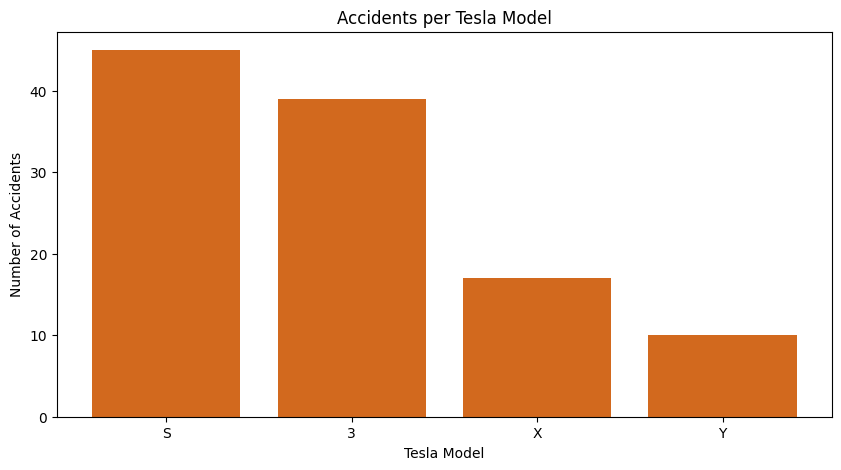

In [23]:
# Model-wise analysis for Tesla car types
model_counts = data['Model'].str.strip().replace("-", "0").value_counts()
model_counts = model_counts[model_counts.index.isin(["S", "X", "Y", "3"])]
plt.figure(figsize=(10, 5))
plt.bar(model_counts.index, model_counts.values, color="chocolate")
plt.xlabel("Tesla Model")
plt.ylabel("Number of Accidents")
plt.title("Accidents per Tesla Model")
plt.show()

## Check the distribution of Verified Tesla autopilot deaths.

1. labeldistance=1.1: Places category labels outside the pie chart for better readability.
2. pctdistance=0.85: Positions percentage labels closer to the slices.
3. textprops={'rotation': 90}: Sets the text rotation to vertical (90 degree), which may reduce clutter.

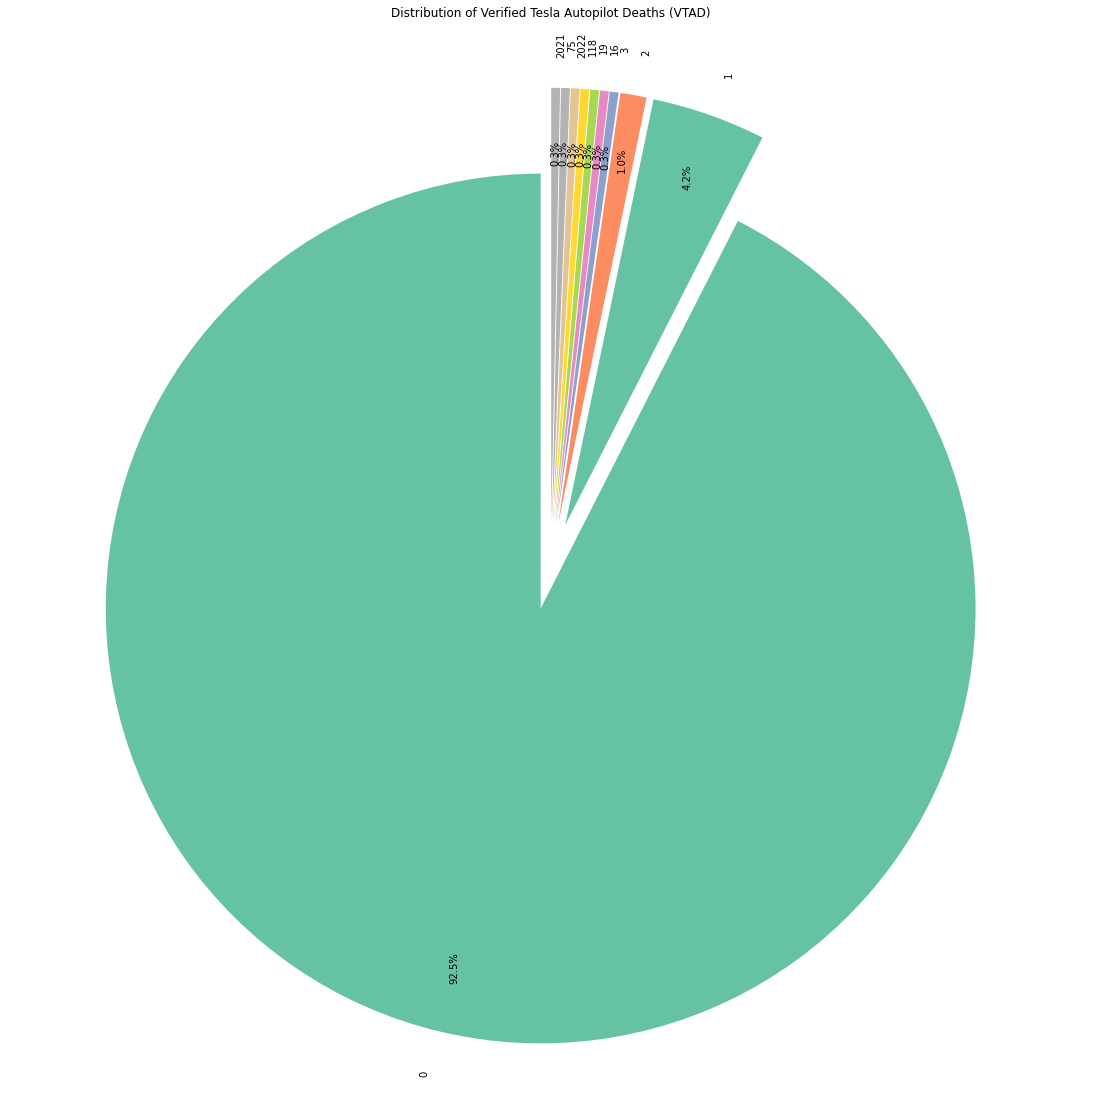

In [13]:
# Verified Tesla Autopilot Deaths (VTAD) distribution

vtad_counts = data['VTAD'].value_counts()
plt.figure(figsize=(20, 20))
vtad_counts.plot.pie(autopct="%1.1f%%", startangle=90, cmap="Set2", textprops={'rotation': 90}, labeldistance=1.1, pctdistance=0.85, explode=[0.1] * len(vtad_counts))
plt.ylabel("")
plt.title("Distribution of Verified Tesla Autopilot Deaths (VTAD)")
plt.show()